In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from collections import Counter
import random
import seaborn as sns
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter 
import pandas as pd
from sklearn.cluster import DBSCAN
from scipy import stats
from fitter import Fitter

In [2]:
# Elegimos cajas cuadradas entre [0, R]
def Puntos_circulos(ncentros, ncircle_points, radio, tcaja, pert, pcenter=0.15, disp_cent=1.5):
    #Definimos dos arreglos de ceros en los que guardaremos en uno las coordenadas x y en otro las y de los puntos que aleatorios de nuestros círculos
    """
    ncentros = numero de centros, numero de circulos
    ncircle_points = numero de puntos por circulo
    radio = tamaño del circulo
    tcaja = tamaño de la caja
    pert = porcentaje de la perturbacion, ruido
    pcenter = porcentaje del numero de puntos en el centro
    disp_cent = dispersion en la distribucion de puntos centro
    """
    
    points_center =  int(ncircle_points*pcenter)
    ran_centros = np.random.uniform(low=0.0, high=tcaja, size=((ncentros,2)))
    x_1, y_1 = ran_centros.T[0], ran_centros.T[1] 
    pts = 0
    circulo = []
    label = []
    for i in range(ncentros):
        cx = []
        cy = []
        ran_pcircles = np.random.uniform(0, 2*np.pi, ncircle_points)
        for j in ran_pcircles:
            r = radio + random.uniform(-radio*pert,radio*pert) #Pertubación
            c_1 = x_1[i] + r*np.cos(j)
            c_2 = y_1[i] + r*np.sin(j)
            #Como los centros de los círculos pueden estar en la orilla, muchos puntos del cículo deseado se pueden 
            #salir de área a estudiar deseada, por lo que sólo guardamos los que quedan dentro
            if (0 < c_1 < tcaja) & (0 < c_2 < tcaja):
                cx.append(c_1)
                cy.append(c_2)
                label.append(i)
                pts+= 1
        #Agregamos puntos en el centro de los círculos con distribución gaussiana
        x = []
        y = []
        x = np.random.normal(x_1[i], disp_cent, points_center)
        y = np.random.normal(y_1[i], disp_cent, points_center)
        for k in range(points_center):
            if (0 < x[k] < tcaja) & (0 < y[k] < tcaja):
                cx.append(x[k])
                cy.append(y[k])
                label.append(i)
                pts+= 1
        # en caso de querer graficar un circulo en particular 
        circulo.append(list(zip(cx, cy)))
    print('total puntos', pts)
    return circulo, label

In [10]:
def DD(circulo):
    # Save them all in one array
    all_data = []
    for i, c in enumerate(circulo):
        for _, j in enumerate(c):
            all_data.append(j)
    return all_data

In [11]:
def centro_masa(n, r):
    return sum(r)/n

In [12]:
#ncentros, ncircle_points, radio, tcaja, pert, pcenter=0.1, disp_cent=1.5
#np.random.seed(431) #Tenemos números pseudoaleatorios, así que para obtener el mismo siempre lo sembramos
circulo, etiqueta= Puntos_circulos(5, 40, 15, 150, 0.05, 0.3,1)
DDcirculo = DD(circulo)
N = len(DDcirculo)
rr = np.random.uniform(low=0.0, high=150.0, size=((N,2)))

total puntos 216


In [13]:
#Para extraer las coordenadas de nuestras galaxias y el circulo a la que pertenece cada uno
df = pd.DataFrame(DDcirculo)
df.insert(2,'label',etiqueta)
print(df)
df.to_csv(r'Shape_5mockgalaxies.txt', header=None, index=None, sep='	', mode='a')

             0           1  label
0     8.568412   77.941639      0
1    21.165880   49.497098      0
2    28.288823   56.886938      0
3     2.858846   54.536129      0
4    17.192139   79.141230      0
..         ...         ...    ...
211  52.523993  113.921093      4
212  53.602211  118.118507      4
213  53.350146  114.134517      4
214  53.788113  114.797857      4
215  54.023429  113.382075      4

[216 rows x 3 columns]


In [14]:
circulos = DDcirculo

In [8]:
#Importampos los datos
datos = np.zeros((len(circulos),2))
for i in range(len(circulos)):
        datos[i,0] = circulos[i][0]
        datos[i,1] = circulos[i][1]

#Importampos los datos
datosrr = np.zeros((len(rr),2))
for i in range(len(rr)):
        datosrr[i,0] = rr[i][0]
        datosrr[i,1] = rr[i][1]

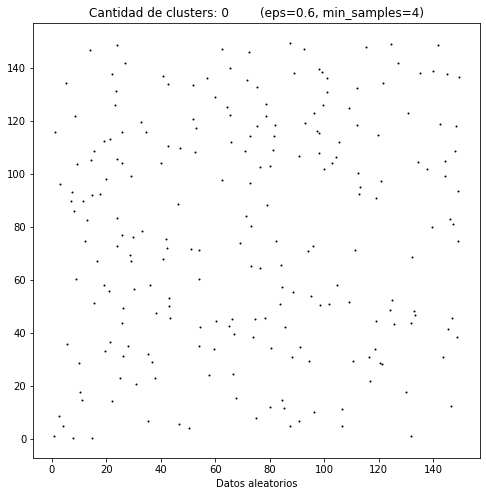

In [9]:
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# DBSCAN
db = DBSCAN(eps=1.5, min_samples=7).fit(datosrr) #eps=2, min_samples=10
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# número de clusters, ignorando el ruido
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(8,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = datosrr[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datosrr[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Cantidad de clusters: %d        (eps=0.6, min_samples=4)' % n_clusters_ )
plt.xlabel('Datos aleatorios')
plt.show()

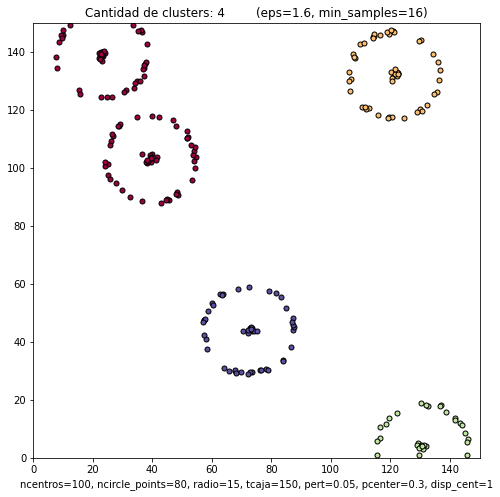

In [230]:
# DBSCAN
db = DBSCAN(eps=15, min_samples=5).fit(datos) #eps=2, min_samples=10
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# número de clusters, ignorando el ruido
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(8,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = datos[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

    xy = datos[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Cantidad de clusters: %d        (eps=1.6, min_samples=16)' % n_clusters_ )
plt.xlabel('ncentros=100, ncircle_points=80, radio=15, tcaja=150, pert=0.05, pcenter=0.3, disp_cent=1')
plt.xlim(0,150)
plt.ylim(0,150)
plt.show() 

In [171]:
df_cluster_datos = pd.DataFrame(datos)

df_cluster_datos['labels'] = labels

pd.set_option("display.max_rows", None, "display.max_columns", None)

print(df_cluster_datos)

               0           1  labels
0     122.941344   72.031757      -1
1     126.738382   63.853327      -1
2     126.812445   62.424342      -1
3     147.380597   83.269727      -1
4     143.980197   58.557413      -1
5     124.208187   67.724146      -1
6     125.001072   64.419283      -1
7     124.305848   70.972629      -1
8     125.630922   80.163011      -1
9     127.800543   62.706472      -1
10    123.630942   73.876307      -1
11    129.787361   60.185275      -1
12    149.355472   61.849165      -1
13    136.049500   57.877598      -1
14    128.096488   83.142388      -1
15    124.628077   76.289068      -1
16    125.108416   67.494194      -1
17    137.498366   87.584441      42
18    147.801807   83.960980      -1
19    141.750551   85.937859      -1
20    131.989102   57.717748       0
21    125.727270   79.679534      -1
22    146.749101   59.868027      -1
23    136.471744   86.441500      42
24    123.609373   72.222910      -1
25    130.925616   84.875985      -1
2

In [172]:
# Para obtener los indices correpondientes de los puntos de cada cluster
mydict = {i: np.where(labels == i)[0] for i in range(n_clusters_)}

# Transformo el diccionario en una lista 
dictlist = []
list_value = []
for key, value in mydict.items():
    temp = [key,value]
    list_value.append(temp)
    dictlist.append(value)

In [173]:
cluster_data = [] #Cada cluster_data[i]entrega todos los puntos que pertenecen a ese cluster
for j in mydict.values():
    cluster_data.append(datos[j])

In [174]:
centros_clusters = np.zeros((len(cluster_data),2))
for i in range(len(cluster_data)):
        centros_clusters[i,0] = centro_masa(len(cluster_data[i][:,0]), cluster_data[i][:,0])
        centros_clusters[i,1] = centro_masa(len(cluster_data[i][:,1]), cluster_data[i][:,1])

In [175]:
len(centros_clusters)

98

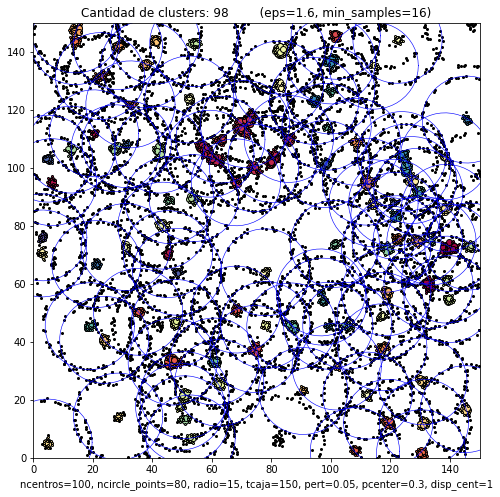

In [176]:
#Plot
# Se remueve el negro y se utiliza para ruído
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(8,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Negro
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = datos[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = datos[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=2)

plt.title('Cantidad de clusters: %d        (eps=1.6, min_samples=16)' % n_clusters_ )
plt.xlabel('ncentros=100, ncircle_points=80, radio=15, tcaja=150, pert=0.05, pcenter=0.3, disp_cent=1')

r = 15
t = np.linspace(0, 2*np.pi)
for i in range(len(centros_clusters)):
    x = centros_clusters[i,0] + (r * np.cos(t))
    y = centros_clusters[i,1] + (r * np.sin(t))
    plt.plot(x,y, color='b', linewidth=0.6)
plt.xlim(0,150)
plt.ylim(0,150)
plt.show()

In [17]:
random_data = stats.gamma.rvs(2, loc=2.5, scale=2, size=5000)

Fitting 5 distributions: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.003595,955.934628,-70701.753144,inf,0.005280,9.989350e-01
beta,0.003617,966.415547,-70662.690116,inf,0.005763,9.960537e-01
lognorm,0.007078,909.644762,-67314.207293,inf,0.018615,6.175343e-02
rayleigh,0.033964,1274.299857,-59481.162800,inf,0.084708,1.162644e-31
cauchy,0.068365,903.079830,-55983.376661,inf,0.143543,2.313638e-90


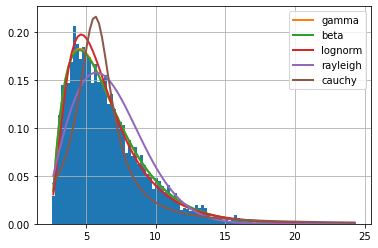

In [266]:
dist_fitter = Fitter(random_data,
                   distributions = ["cauchy",
                                    "rayleigh",
                                    "beta",
                                    "gamma",
                                    "lognorm"])       
dist_fitter.fit()
dist_fitter.summary()     

In [ ]:
dist_fitter = Fitter(random_data,
                   distributions = ["cauchy",
                                    "rayleigh",
                                    "beta",
                                    "gamma",
                                    "lognorm"])       
dist_fitter.fit()
dist_fitter.summary()     